<font color="#483D8B">
<h1  align="center">Final Project: Credit Card Fraud Detection</h1>
<h3 align="center">
INET4710 <br> Spring 2019<br>
By Natalie Hong<br></h3>
</font>

## Overview


Business problem: We want to determine if we're able to 100% accurately detect fradulent transactions while minimizing incorrect fraud classifications. We will be using technique anomaly detection to identify unusual patterns that don't conform to expected behaviors, called outliers. Many businesses use this to track intrusions, system health monitoring, and fraud detection.

Objectives:
* Do EDA on dataset
* Split datset to train and test sets
* Predict and evaluate validation set on Isolation Forest, Local Outlier Factor and Support Vector Machine models
* Predict and evaluate validation set on Autoencoder in Keras
* Compute different models with dataset and choose the one that was most accurate

Models: the models that are being created are isolation forest, local oulier factor (LOF), SVM and autoencoder. An LOF model is being used because it's based on a distance metric called reachability distance. SVM can also detect anomalies. 

References:
* https://www.datascience.com/blog/fraud-detection-with-tensorflow
* https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras
* https://github.com/jimmycy93/Credit-Card-Fraud-Detection
* https://www.kaggle.com/renjithmadhavan/credit-card-fraud-detection-using-python
* https://www.kaggle.com/pavansanagapati/anomaly-detection-credit-card-fraud-analysis

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Data

Dataset: this dataset is taken over a span of 2 days in Septemeber 2013, with 284807 transactions from European cardholders. Out of 284807 transactions, there were 492 transactions that were detected as fraud. It's an unbalanced dataset. The input variables are a result of PCA transformation. To maintain privacy, there are some information that cannot be shared publicly. 
* Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df1 = df.sample(frac = 0.1, random_state=1)
df1.shape

(28481, 31)

we're going to take a sample of the dataset for computing models and prediction.

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Exploratory Data Analysis

The dataset consists of results from a PCA, it ranges from V1-V29. In this section, we will take a look at how to data looks like with the two categories of fraud and normal. Some data profiling we'll be doing is looking at how the datset looks like. We know that the dataset is highly unbalanced between the two categories, but it's hard to really know until we are able to visualize it. The dataset will also be put into training and test sets. The preprocessing steps for autoencoder will be different compared to the other models.

Some questions that will be answered are:
* How many transactions are fraudulent and how many are not?
* What is the amount of money used in transactions for fraud and normal ones?
* At what hour do fraud transcations occur?
* Does the time of the transaction affect the amount?

In [5]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(df.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


Here we're counting which credit card transactions were fraud (1) and transactions that aren't fraud (0). There are way more transactions that are fraud, which is a good thing, but it makes the dataset unbalanced. Below is a visual of just how much the difference is. The dataset is highly imbalanced as there are more normal transactions that fraudulent ones.

In [6]:
df.isnull().values.any()

False

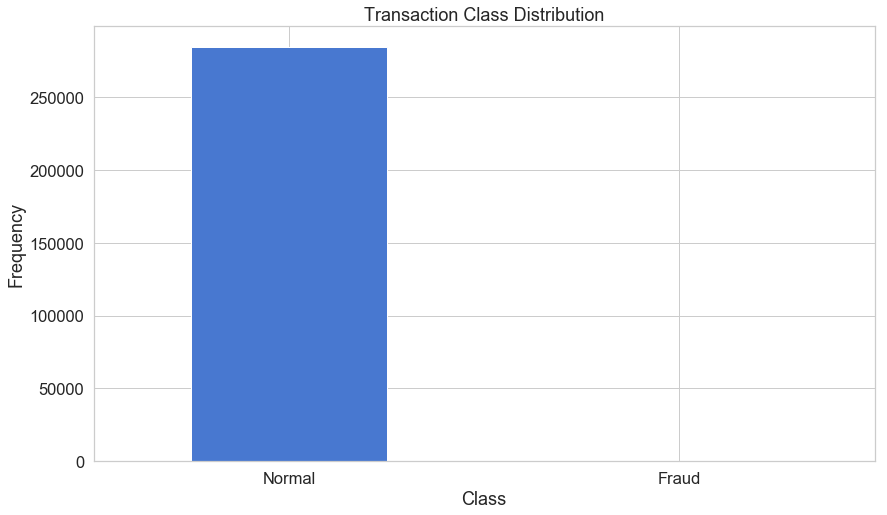

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency");

Each column in the datset is plotted and put into a subplot for a easier view of how the data looks like.

In [8]:
frauds_t = df[df.Class == 1]
normal_t = df[df.Class == 0]
frauds_t.shape

(492, 31)

In [9]:
frauds_t.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal_t.shape

(284315, 31)

In [11]:
normal_t.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

This shows us the amount of money being used in normal transactions and fraud transactions. The average amount of money for normal transactions is 88.29. But for fraud transactions, the average amount goes up to $122.21. Below is a chart version to see which amount is used. It seems for normal transactions, we have outliers where cardholders are making some big transactions amounts.

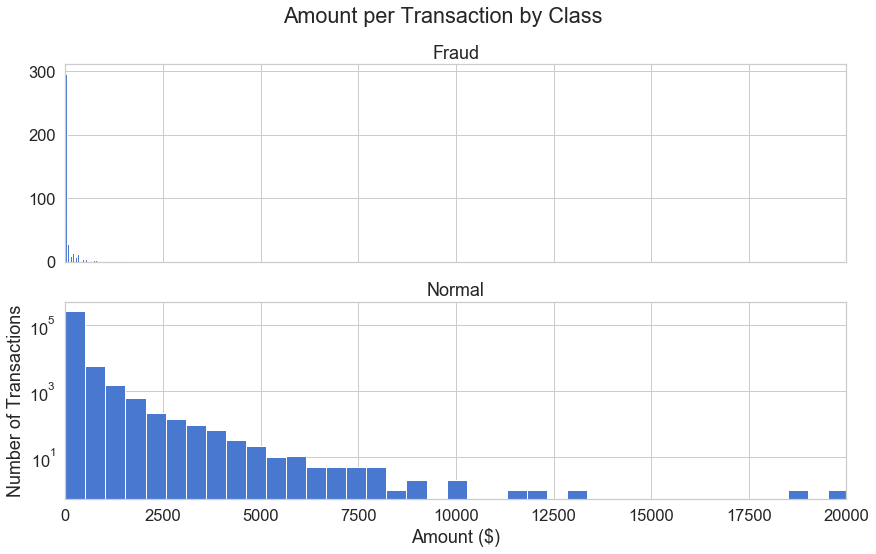

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per Transaction by Class')

bins = 50

ax1.hist(frauds_t.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal_t.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

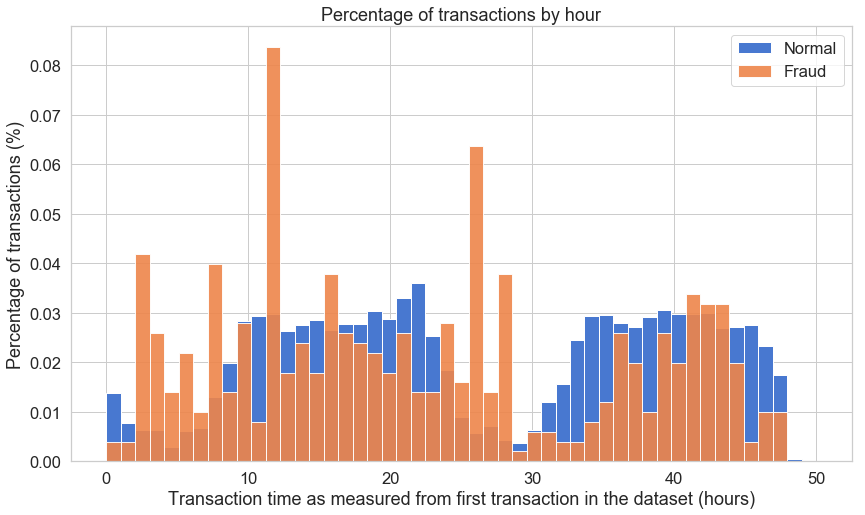

In [13]:
bins = np.linspace(0, 50, 50) #48 hours
plt.hist((normal_t.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((frauds_t.Time/(60*60)), bins, alpha=0.9, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

This shows a bar graph of the percentage of transactions made by the hour. It looks like for the fraudulent transactions, they're made either in the afternoon or at midnight to 3am. That's when high activity occurs. In comparison to normal transactions, they're made mostly during the day time.

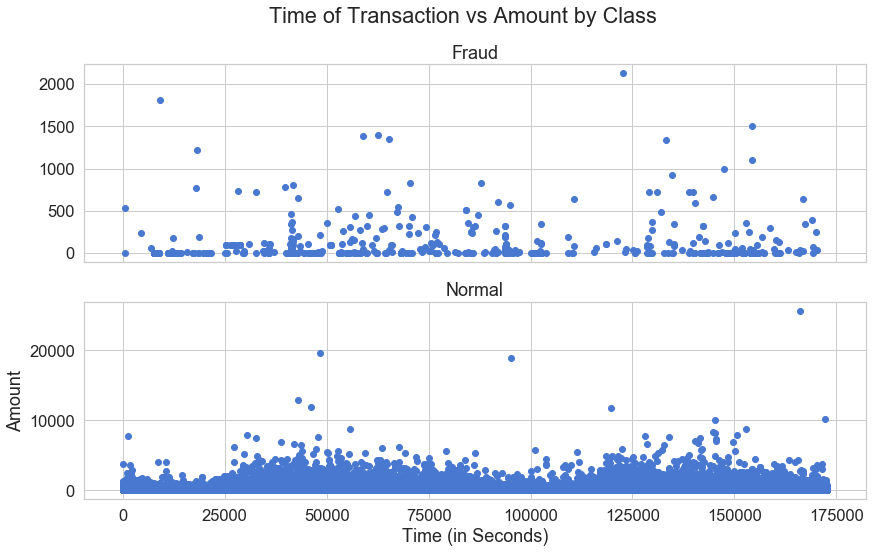

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of Transaction vs Amount by Class')

ax1.scatter(frauds_t.Time, frauds_t.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal_t.Time, normal_t.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

This is a representation of both normal transactions and fraud transactions. We are looking to see if there is a certain time that fraud transactions are occuring compared to when normal transactions are. From the data, it looks like the fraud transactions are occuring just about any time like normal transactions.

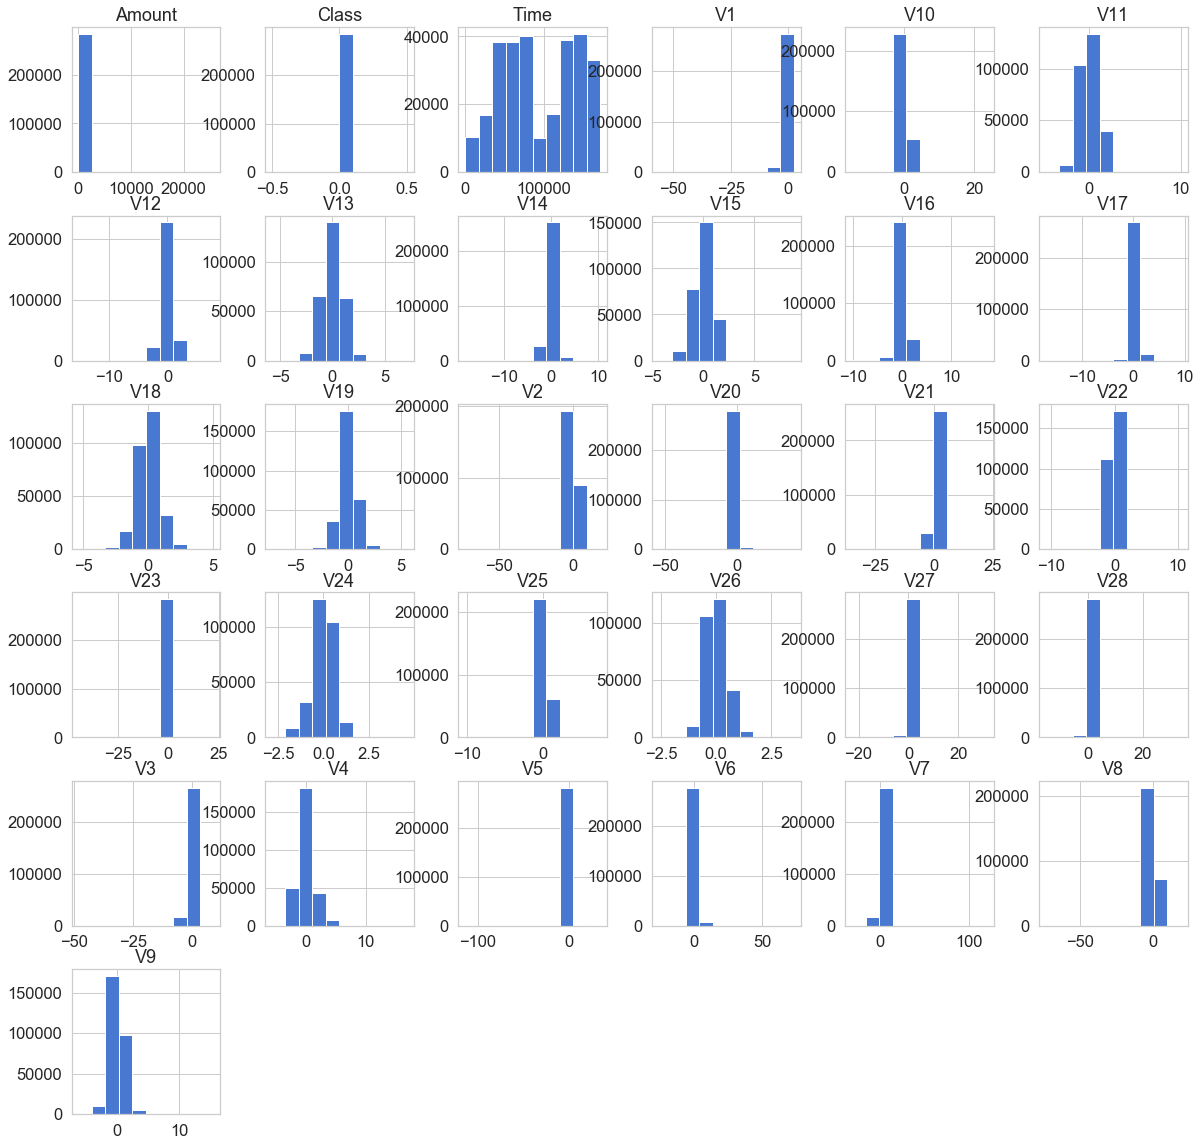

In [15]:
normal_t.hist(figsize=(20,20))
plt.show()

Each parameter is plotted on a histogram

In [16]:
Fraud = df1[df1.Class == 1]

Valid = df1[df1.Class == 0]

outlier_fraction = len(Fraud)/float(len(Valid))

In the smaller dataset we created a 10% fraction of the original, we'll be using that to run on models for faster computation and find any outliers.

In [17]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


This sample of the database has a total of 28481 transactions. 49 of those are fraudulent, and 28432 are valid.

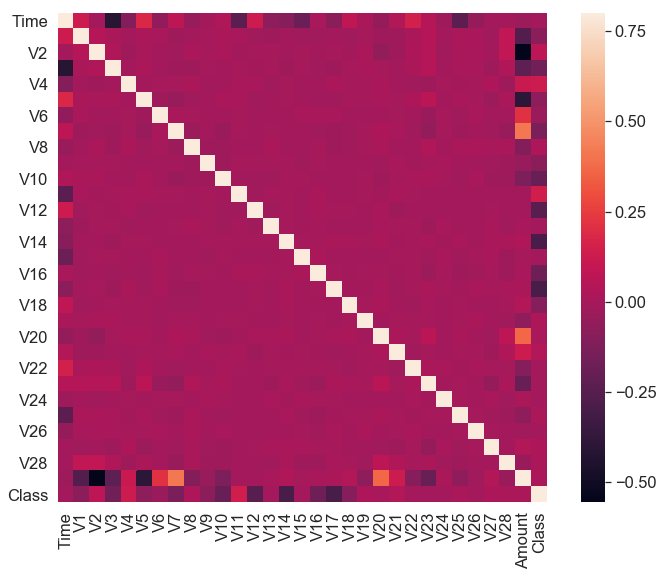

In [18]:
#Correlation Matrix
correlation_matrix = df1.corr()

fig = plt.figure(figsize=(12,9))

sns.heatmap(correlation_matrix,vmax=0.8,square = True)

plt.show()

Based on the heatmap created, none of the PCA components V1-V28 have any correlation to eachother. But if you look at "Class" you can see that there are some negative or positive correlations with the PCA components.

In [19]:
columns = df1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df1[columns]
Y = df1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


This training set and test set are going to be used for the isolation forest, LOF and SVM models.

### Preprocessing for Autoencoder

In [20]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

We're going to train the autoencoder by importing standardscaler. This will remove the time. Mean, and values are scales to unit variances. To use the autoencoder, we want to detect anomaly in new transactions. The model will only train the normal data for this situation and 20% of the data will be saved for testing. The PCA done on the dataset transformed it into standard-normal form so "Amount" will also become standard-normal form.

In [21]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [22]:
X_train.shape

(227451, 29)

## Models

1. Isolation Forest Algorithm <br/>
This technique is a new one that can detect anomalies. It's based on anomalies being data points that are few and different. Anomalies are suceptible to isolation. This algorithm has a low linear time complexity and small memory requirement. It builds a good performing model with a small number of trees using sub-samples of fixed sizes regardless of the size of dataset. The algorithm will select a random feature then select a random split value to isolate anomaly observations. 

2. Local Outlier Factor (LOF) Algorithm <br/>
This algorithm is an unsupervised outlier detection method. It computes local density deviation of a given data point with respect to its neighbors. It's considers as outlier examples that have a substantially lower density than its neighbors. 

3. Support Vector Machine (SVM) Algorithm <br/>
A SVM usually works with supervised learning, but the extension OneClassSVM can be used to detect anomalies as unsupervised problems. The algorithm learns a soft boundary to cluster the normal data using the training set, then using test set, it tunes itself to identify anomalies outside the learned region.

4. Autoencoder <br/>
Lastly, an autoencoder is being used to learn a representation (encoding) for a dataset, for dimensionality reduction. The autoencoder learns to compress the data from input layer then uncompress it into something that closely matches the original dataset.



Looking at the other references they used logistic regression, random forest, or another model. Those models were used on resampled data. But since this code is used to detecting anomalies in the normal dataset, I saw that these models were a better choice for the dataset to run on. It was also cleaner and there's less confusion on evaluating the models.


For the autoencoder, the parameter are put in that way so the reconstruction error is minimized. For the other models, the first parameters were default. Isolation forest took in parameter for the size of the dataset, outlier fraction and default everything else. For LOF, auto algorithm was used to decide the most appropriate algorithm based on the fit and outlier fraction was used. Everything else was default. For SVM, gamma is 0.1 and everything else was default.

### Isolation Forest, Local Outlier Factor, Support Vector Machine Models

In [23]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)
   
}

In [24]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

   micro avg       1.00      1.00      1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 8516
Accuracy Score :
0.7009936448860644
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70   

### Autoencoder

Autoencoders are a type of neural network that takes an input (e.g. image, dataset), boils that input down to core features, and reverses the process to recreate the input. This will reconstruct what non fradulent transactions look like. 

In [25]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [26]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


The model is trained for 100 epochs with batch size of 32 samples. Below is where we set up the actual run including checkpoints and the tensorboard.

In [27]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.8120 - acc: 0.5877 - val_loss: 0.7855 - val_acc: 0.6385
Epoch 2/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7460 - acc: 0.6403 - val_loss: 0.7744 - val_acc: 0.6466
Epoch 3/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7364 - acc: 0.6479 - val_loss: 0.7665 - val_acc: 0.6512
Epoch 4/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7308 - acc: 0.6559 - val_loss: 0.7629 - val_acc: 0.6716
Epoch 5/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7271 - acc: 0.6631 - val_loss: 0.7603 - val_acc: 0.6666
Epoch 6/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7247 - acc: 0.6684 - val_loss: 0.7584 - val_acc: 0.6747
Epoch 7/100
227451/227451 [============================

In [28]:
autoencoder = load_model('model.h5')

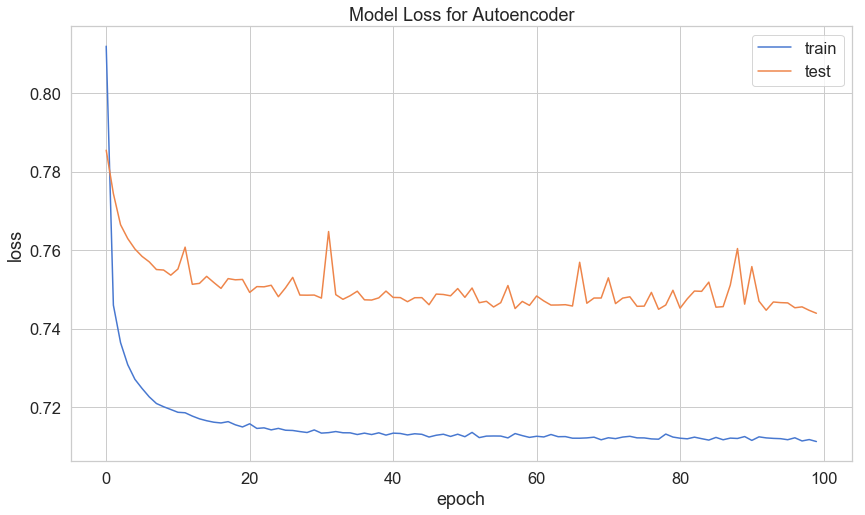

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss for Autoencoder')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

As there are more epochs that training the model goes through, loss is decreased.

In [30]:
predictions = autoencoder.predict(X_test)

In [31]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [32]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.735405,0.001720
std,3.460225,0.041443
min,0.054840,0.000000
25%,0.241086,0.000000
50%,0.386207,0.000000
75%,0.611523,0.000000
max,262.082237,1.000000


Autoencoders are trained to reduce reconstruction error which we show below

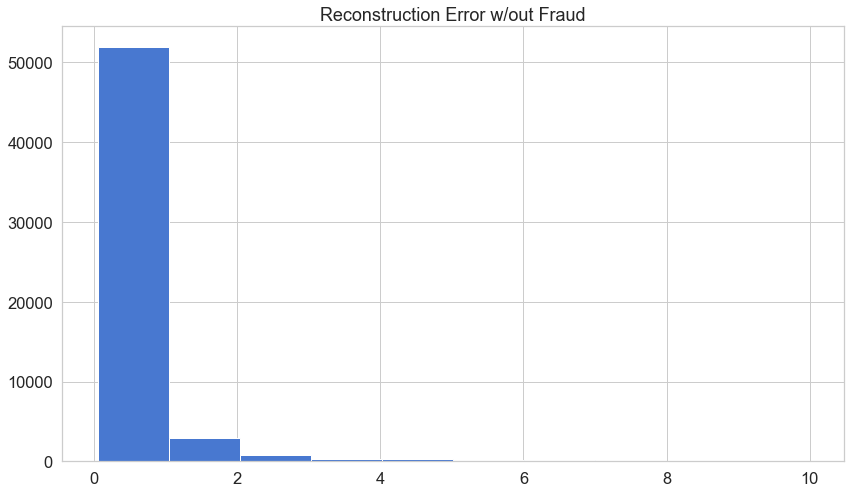

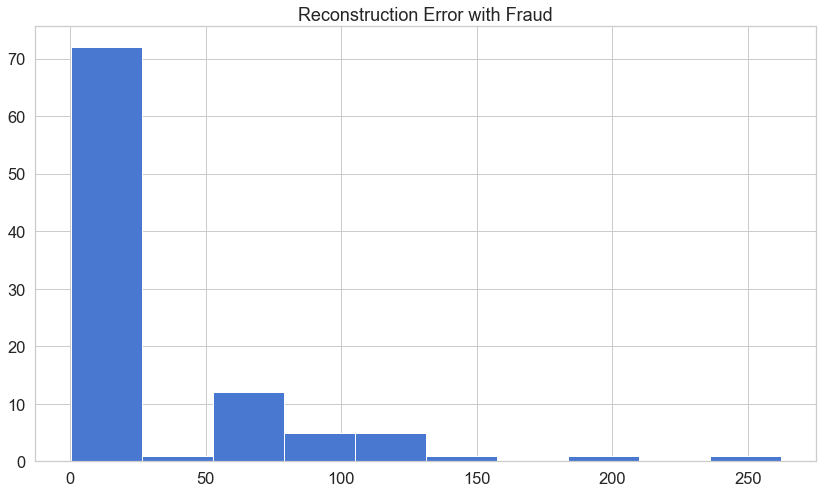

In [33]:
#Reconstruction error without fraud
fig = plt.figure()
plt.title('Reconstruction Error w/out Fraud')
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

#Reconstruction error with fraud
fig = plt.figure()
plt.title('Reconstruction Error with Fraud')
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

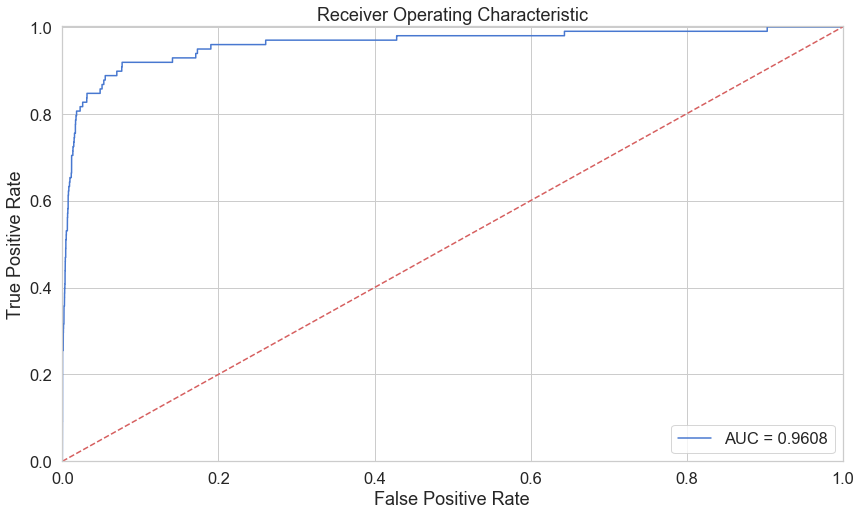

In [34]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. The AUC score is 0.9608.

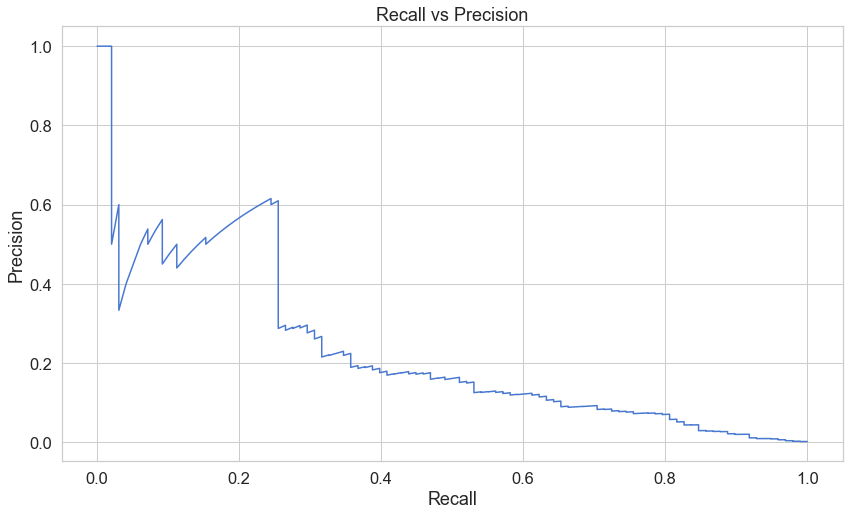

In [35]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. High recall but low precision means many results, most of which has low or no relevancy. The goal is to get high precision and recall where it means that many of the obtained results will be relevant. There is a point on the graph that has high precision and high recall.

In [42]:
threshold = 5

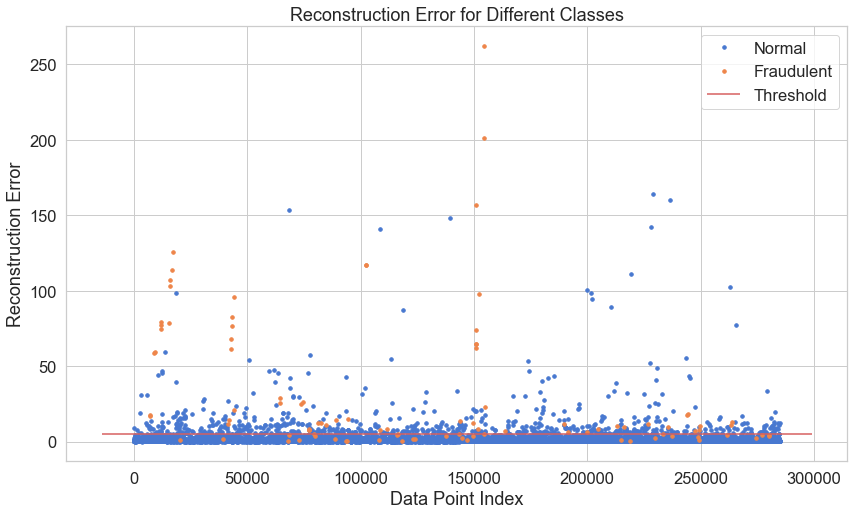

In [43]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraudulent" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for Different Classes")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show();

If we want to predict whether or not a new/unseen transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we’ll mark it as a fraud.

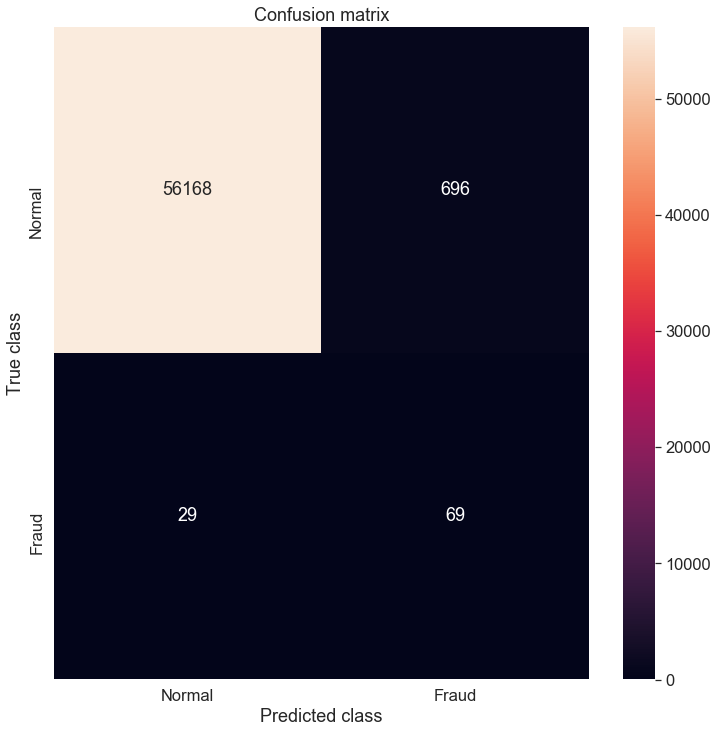

In [44]:
pred_y = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We create a traditional confusion matrix for the 20% of the data we randomly held back in the testing set. 40% of the fraud cases were detected where 29 cases were predicted normal but were fraud out of the 69.

## Results

The Classification Report for the Isolation Forest, LOF, and SVM models showed that the Isolation Forest model was the most accurate. 
* Each of them detected different amounts of errors; isolation forest had 73 errors, local outlier factor had 97 errors, and SVM had 8516 errors. 
* Accuracy score for isolation forest is 99.74%, LOf is 99.66% and SVM is 70.10%
* Precision and recall score for isolation for isolation forest as 27%, LOF was 2% and SVM was 0% for precision and 37% for recall which could show how that model detected so many fraud cases.
* The best accuracy score was for the isolation forest
* Sources for error are the scores can change if the dataset was balanced, dataset can be bigger to have more fraud cases

The Autoencoder has 4 layers, 2 encoding and 2 decoding. 
* On the model loss graph, the loss while being reconstructed decreased as we kept doing epochs. 
* The reconstruction error without fraud is less than the reconstruction error with fraud. 
* AUC was 0.9585 and close to the edge
* Recall and Precision showed slightly higher around 0.2 and 0.6 where it's returning accurate results and positive results

## Conclusion

For the 3 models that were run to detect any anomalies for fraud cases, two of them were very accurate. Both had 99% with one just slightly more accurate. Isolation Forest was the overall winner. SVM was only 70% accurate. But the accuracy of those models can change if the dataset had more fraud cases or if we could balance it. An autoencoder is an artificial neural network that basically tries to reconstruct the original data. As much as we want to be 100% accurate in detecting fraud cases, it won't be true in real life. What we can do is add more fraud detection systems to hopefully catch them one way or another. Recommendations: since the data was highly skewed and unbalance, if there was a way to find information about more of the dataset, then we could balance it out and test the train set with test set equally. We can also increase the sample to be more that 10% of the database or pick different deep learning algorithms to determine more fraud cases.